## The bulk of this notebook is copied from the excellent: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
### I add to this:
* Merge OOF (out-of-CV-fold) ImageNets predictions into the train set / use as a feature ("imagenet_predict")
* Same folds defined in ImageNet predictions are re-used in tabular training to avoid data-leakage
* For test data images - all 5 folds of the ImageNet models are run and the average is used to populate "imagenet_predict"

## See https://www.kaggle.com/code/richolson/isic-2024-imagenet-train-oof-preds-public for a public example of how to train an ImageNet / generate OOF predictions
* That notebook is a de-optimized version of my private imagenet notebook
* Doesn't do much as-is - but is a handful of tweaks away from performing well

### Version 1 of this notebook (.181 LB) uses OOF predictions and ImageNets that are private (sorry!)
* Can't submit for competition

### Version 3 and later of this notebook uses the public OOF predictions and ImageNet
* You should be able to submit it - but no promises on LB score

In [9]:
# !pip install imblearn
# !pip install optuna

In [51]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import optuna
from torchvision.io import read_image

In [32]:
root = os.path.join('materials', 'ISIC-2024_CS640')
train_path = os.path.join(project_dir, 'train_metadata.csv')
test_path = os.path.join(project_dir, 'test_metadata.csv')
subm_path = os.path.join(project_dir, 'submission.csv')
# IMAGE_PATH = os.path.join(project_dir, 'train_image')

In [33]:
# root = Path('/kaggle/input/isic-2024-challenge')

# root = Path('./materials/ISIC-2024_CS640')

# train_path = root / 'train-metadata.csv'
# test_path = root / 'test-metadata.csv'
# subm_path = root / 'sample_submission.csv'


id_col = 'id'
target_col = 'target'
# group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]
# for i in num_cols:
#     print(i)
new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple']#, 'attribution']
# norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
# special_cols = ['count_per_patient']
feature_cols = num_cols + new_num_cols + cat_cols #+ norm_cols + special_cols

In [34]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        # .with_columns(
        #     ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        # )
        # .with_columns(
        #     count_per_patient = pl.col('isic_id').count().over('patient_id'),
        # )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

In [35]:
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [68]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.image as img
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    fpr, tpr, thresholds = roc_curve(v_gt, v_pred)

    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    
    return partial_auc

### Data Read & Feature Engineering

In [37]:
df_train = read_data(train_path)
df_test = read_data(test_path)
df_subm = pd.read_csv(subm_path, index_col=id_col)

df_train, df_test = preprocess(df_train, df_test)

/scratch/1443786.1.l40s/ipykernel_477433/2394458942.py:71: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(
/scratch/1443786.1.l40s/ipykernel_477433/2394458942.py:71: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  .with_columns(


# Add in OOF imagenet preds

In [40]:
oof_image_net_preds = pd.read_csv("./Training_Results/Cheat/oof_predictions_v1.csv")
oof_image_net_preds.rename(columns={'isic_id': 'id'}, inplace=True)
print(oof_image_net_preds['id'])

0              0
1              1
2              2
3              3
4              4
           ...  
320842    320842
320843    320843
320844    320844
320845    320845
320846    320846
Name: id, Length: 320847, dtype: int64


In [41]:

# Rename the 'oof_prediction' column to 'imagenet_predict'
image_pred_col = "imagenet_predict"
oof_image_net_preds = oof_image_net_preds.rename(columns={'oof_prediction': image_pred_col})

# Merge with df_train on 'isic_id', adding both 'fold' and the prediction column
df_train = df_train.merge(oof_image_net_preds[['id', 'fold', image_pred_col]], 
                          on='id', 
                          how='left')

# Add the new column to feature_cols
feature_cols.append(image_pred_col)

# Print some information about the merged dataframe
print(f"Shape of df_train after merge: {df_train.shape}")
print(f"Number of null values in {image_pred_col}: {df_train[image_pred_col].isnull().sum()}")
print(f"Number of null values in fold: {df_train['fold'].isnull().sum()}")
print(f"Unique values in fold: {df_train['fold'].unique()}")

Shape of df_train after merge: (320847, 126)
Number of null values in imagenet_predict: 0
Number of null values in fold: 0
Unique values in fold: [0 1 2 3 4]


# ImageNet inference code

In [49]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import h5py
import timm
from torchvision import transforms
from PIL import Image
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2

epoch_for_preds = 1
model_path = './'

class ISICDataset(Dataset):
    # def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
    def __init__(self, df, isic_ids, targets=None, transform=None):
        self.df = df
        # self.hdf5_file = hdf5_file
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, idx):
        # print(self.df[self.df['id'] == idx]['filename'].values[0])
        img = read_image(self.df[self.df['id'] == idx]['filename'].values[0])
        
        img = np.array(img)
        img = img.transpose(1, 2, 0)
        # print(img.shape)
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
            # print(img.shape)
        
        if self.targets is not None:
            target = self.targets[idx]
        else:
            target = torch.tensor(-1)  # Dummy target for test set
            
        return img, target
    
# Prepare augmentation
aug_transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.1, p=0.5),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

def setup_model(num_classes=2):
    return timm.create_model('tf_efficientnetv2_b1', pretrained=False, num_classes=num_classes)

def load_models(folds, device):
    models = []
    for fold in folds:
        model = setup_model().to(device)
        model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds}.pth', map_location=device))
        model.eval()
        models.append(model)
    return models

@torch.no_grad()  # Apply no_grad to the entire function
def ensemble_predict(models, test_loader, device):
    all_predictions = []
    for inputs, _ in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        fold_predictions = torch.stack([model(inputs).softmax(dim=1)[:, 1] for model in models])
        avg_predictions = fold_predictions.mean(dim=0)
        all_predictions.extend(avg_predictions.cpu().numpy())
    return all_predictions


/scratch/1443786.1.l40s/ipykernel_477433/376570478.py:52: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


# Do ImageNet inference on test data / merge df_test

In [52]:
# TEST_HDF5_FILE_PATH = '/kaggle/input/isic-2024-challenge/test-image.hdf5'

TRAIN_PATH = os.path.join(project_dir, 'test_image')
data_df = pd.read_csv(os.path.join(project_dir, "test_metadata.csv"))
# data_df['target'] = data_df['target'].astype(np.int32)
data_df['filename'] = data_df['id'].apply(lambda x: os.path.join(TRAIN_PATH, f"{x}.jpg"))

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# folds to use for pred
folds = [0, 1, 2, 3, 4]

models = load_models(folds, device)

# Prepare your test dataset
test_dataset = ISICDataset(
    df = data_df,
    isic_ids=df_test.index.values,  #minor change here from 
    transform=base_transform,
)    

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=0, pin_memory=True)

# Run predictions
predictions = ensemble_predict(models, test_loader, device)

# Create a new DataFrame with predictions
temp_df = pd.DataFrame({image_pred_col: predictions}, index=df_test.index)

# Join the predictions to df_test
df_test = df_test.join(temp_df)


Using device: cuda


/scratch/1443786.1.l40s/ipykernel_477433/376570478.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoc

### Optuna HyperParam Tuned Models

In [53]:
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     seed,
    'lambda_l1':        0.08758718919397321, 
    'lambda_l2':        0.0039689175176025465, 
    'learning_rate':    0.03231007103195577, 
    'max_depth':        4, 
    'num_leaves':       103, 
    'colsample_bytree': 0.8329551585827726, 
    'colsample_bynode': 0.4025961355653304, 
    'bagging_fraction': 0.7738954452473223, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 85, 
    'scale_pos_weight': 2.7984184778875543,
}

lgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', lgb.LGBMClassifier(**lgb_params)),
])

In [54]:
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        200,
    'verbose':           False,
    'random_state':      seed,
    'max_depth':         7, 
    'learning_rate':     0.06936242010150652, 
    'scale_pos_weight':  2.6149345838209532, 
    'l2_leaf_reg':       6.216113851699493, 
    'subsample':         0.6249261779711819, 
    'min_data_in_leaf':  24,
    'cat_features':      cat_cols,
}

cb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', cb.CatBoostClassifier(**cb_params)),
])

In [55]:
xgb_params = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       seed,
    'learning_rate':      0.08501257473292347, 
    'lambda':             8.879624125465703, 
    'alpha':              0.6779926606782505, 
    'max_depth':          6, 
    'subsample':          0.6012681388711075, 
    'colsample_bytree':   0.8437772277074493, 
    'colsample_bylevel':  0.5476090898823716, 
    'colsample_bynode':   0.9928601203635129, 
    'scale_pos_weight':   3.29440313334688,
}

xgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', xgb.XGBClassifier(**xgb_params)),
])

In [56]:
estimator = VotingClassifier([
    ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
], voting='soft')

### Cross Validation
* Using folds from OOF ImageNet predictions

/usr4/cs640/gsinghal/.local/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


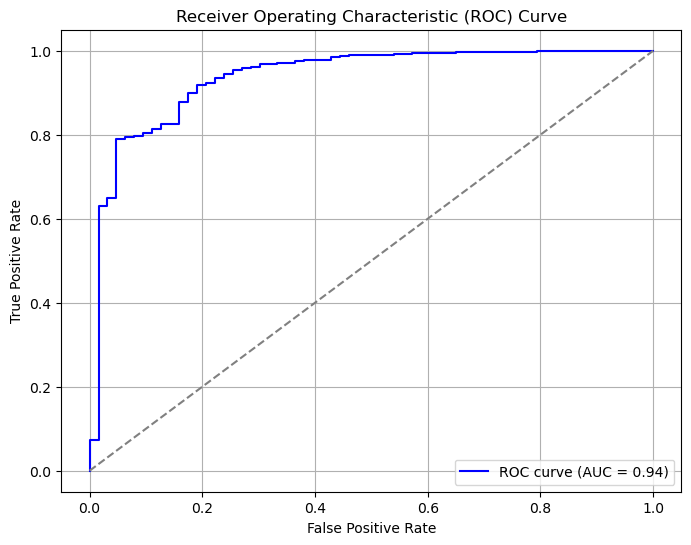

/usr4/cs640/gsinghal/.local/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


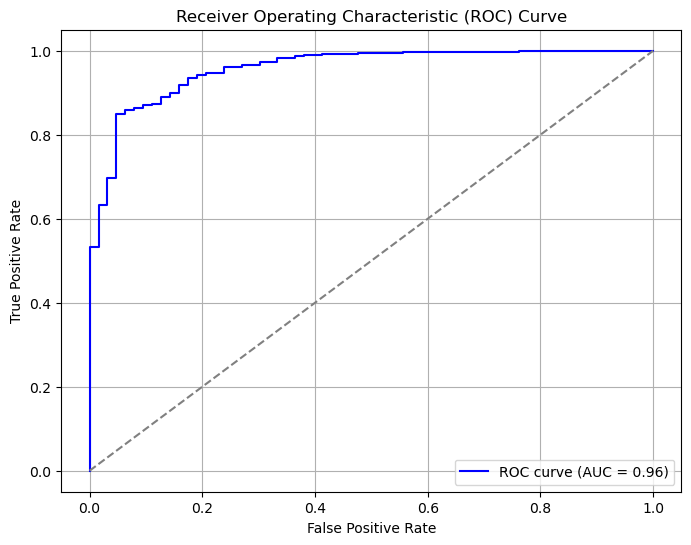

/usr4/cs640/gsinghal/.local/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


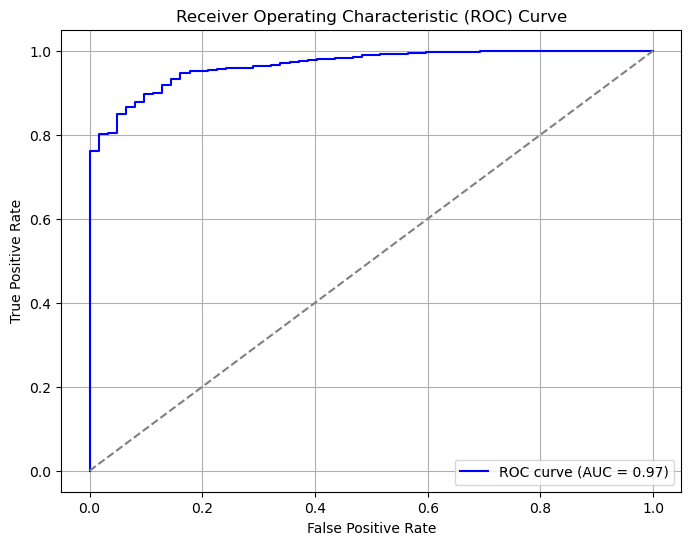

/usr4/cs640/gsinghal/.local/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


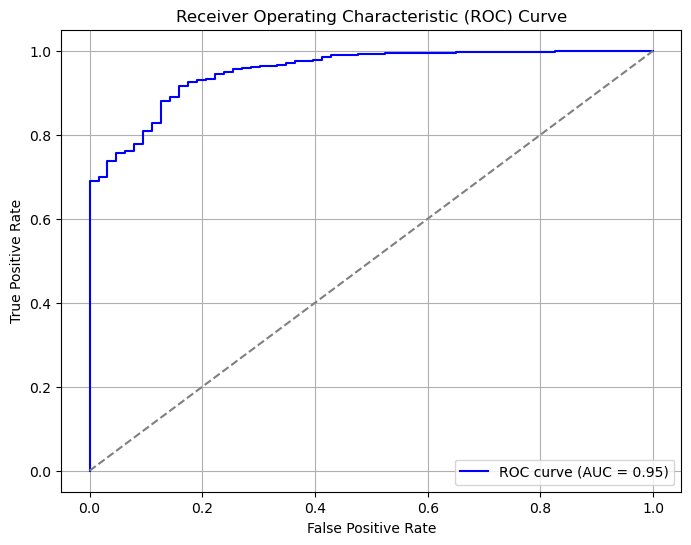

/usr4/cs640/gsinghal/.local/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


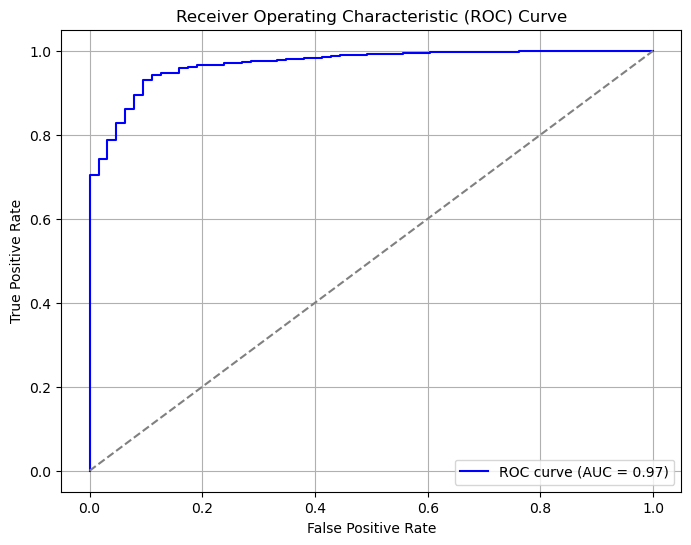

(0.16535803142611222,
 array([0.14806154, 0.16484503, 0.17559071, 0.16236031, 0.17593257]))

In [69]:
from sklearn.model_selection import PredefinedSplit

# Assuming df_train already has a 'fold' column with values 0-4
X = df_train[feature_cols]
y = df_train[target_col]

# Create a PredefinedSplit object using the 'fold' column
fold_indices = df_train['fold'].values
cv = PredefinedSplit(fold_indices)

# Perform cross-validation
val_score = cross_val_score(
    estimator=estimator, 
    X=X, y=y, 
    cv=cv,
    scoring=custom_metric,
)

np.mean(val_score), val_score

### Training

In [58]:
X, y = df_train[feature_cols], df_train[target_col]

estimator.fit(X, y)

/usr4/cs640/gsinghal/.local/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


VotingClassifier(estimators=[('lgb',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=42,
                                                                  sampling_strategy=0.01)),
                                              ('classifier',
                                               LGBMClassifier(bagging_fraction=0.7738954452473223,
                                                              bagging_freq=4,
                                                              colsample_bynode=0.4025961355653304,
                                                              colsample_bytree=0.8329551585827726,
                                                              lambda_l1=0.08758718919397321,
                                                              lambda_l2=0.0039689175176025465,
                                                              learning_rate...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             lambda=8.879624125465703,
                                                             learning_rate=0.08501257473292347,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None, ...))]))],
                 voting='soft')

### Prediction

In [63]:
df_subm['target'] = estimator.predict_proba(df_test[feature_cols])[:, 1]

df_subm.to_csv('submission.csv')
df_subm[df_subm['target'] > 0.9]

,target
id,
1970,0.941298
16234,0.916540
16430,0.932869
22441,0.964075
31121,0.901970
37878,0.905863
41168,0.940788
60975,0.919613
63911,0.955616
